In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls /content/gdrive

Mounted at /content/gdrive
MyDrive


In [3]:
%cd /content/gdrive/My\ Drive/Thesis/MovieLens20M

/content/gdrive/My Drive/Thesis/MovieLens20M


In [4]:
!pip install decord

     |████████████████████████████████| 13.6 MB 4.3 MB/s 


In [5]:
import numpy as np
import glob
import os
import pandas as pd
import cv2
import math   
from decord import VideoReader
from decord import cpu, gpu
import tensorflow as tf
import tensorflow.keras as keras
import gc
import tensorflow.keras.backend as K

#Loaders

In [6]:

def load_name(csv_path,id):
    df= pd.read_csv(csv_path)
    ids = df['ID_Frame']
    return (df.loc[ids == id])['Name'].astype(str)
def load_label(df,id):
    ids = df['ID_Frame']
    genres_str = (df.loc[ids == id])['Genres'].values.tolist()
    if genres_str:
        genres = genres_str[0].strip('\"[\'\'\']\"').split('|')
        return genres
    else:
        return []
def load_label2(df,id):
    ids = df['ID_Frame']
    genres_str = (df.loc[ids == id])['Genres_subset'].values.tolist()
    if genres_str:
        genres = genres_str[0].strip('\"[\'\'\']\"').split('|')
        return genres
    else:
        return []

def load_frames_list(df,id):

    ids = df['ID_Frame']
    if  (df.loc[ids == id])['Number_Scenes'].values.astype(int)>0:
        return (df.loc[ids == id])['Cut_Points'].apply(lambda x:   [list(map(int, a.split(","))) for a in  np.array(x.replace(' ','').strip(']][[').split("],["))]).tolist()[0]

    else:
        return []

df = pd.read_csv( 'CsvFiles/3class_trial.csv')
df["Genres_subset"]=df["Genres_subset"].apply(lambda x:x.strip('][').replace('\'','').replace(' ','').split(","))

df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
print(df)



     ID_Frame  ... Genres_subset
0        4086  ...     [Romance]
1        4571  ...      [Comedy]
2        5758  ...      [Horror]
3        1527  ...      [Comedy]
4        3863  ...      [Horror]
..        ...  ...           ...
324      2363  ...      [Horror]
325      4128  ...      [Horror]
326      1918  ...      [Comedy]
327      1993  ...      [Horror]
328      6582  ...      [Comedy]

[329 rows x 5 columns]


In [33]:
'from tensorflow.keras.utils import Sequence'


class DataGenerator(tf.keras.utils.Sequence):
    '''
        csv_file: CSV file should include cut points, number of scenes, genres, id frame. 
        data_folder : give folder that the data -videos / trailers - is located 
        batch size : give batch size.
        x_label : video_ids
        y_label : genres / labels column
        main_genre : all genre / labels you want to train from 
        dim : dimension of the frames 
            dim should be four dimensional. (give without the RGB CHANNEL for ex. (100,100).)
        frame_rate :  how many frames we select from each of the scenes. Give a even number (!)
        x_label : video ids column name in the dataframe. 
        y_label : genre labels column name in the dataframe
        cut_points_column : list of cutpoints column name in the dataframe (For example  Scenes)
        size_of_cut_list_column: number of sceness of that video. (For example: Number Scenes)
        shuffle : if shuffle (True or false.)
        
        
    '''
    def __init__(self,data_folder,batch_size,n_classes,cut_points_column,frame_rate,csv_file,x_label,y_label,main_genre,size_of_cut_list_column, 
                 preprocess = False, shuffle = True,dim = (100,100), is_test = False):#Initializing the values
        self.is_test = is_test
        self.dim = dim
        self.main_genre = main_genre
        self.data_folder = data_folder
        self.frame_rate = frame_rate
        self.x_label = x_label
        self.y_label = y_label
        self.cut_points_column = cut_points_column
        self.stats = csv_file
        self.video_ids = self.stats[self.x_label].tolist()
        self.video_ids = [str(data_folder+'/'+str(a)+".mp4") for a in self.video_ids]
        
        #No more needed snce we have the function called df_to_list  
        # automatically have the struct for the video_id , frame_begin, frame_end for each of the scenes.
        # self.cut_points =self.stats[cut_points_column].apply(lambda x:[list(map(int, a.split(","))) for a in  np.array(x.strip(']][[').split("], ["))]).tolist()
        self.size_of_cut_list_column = size_of_cut_list_column
        self.genres=self.stats[self.y_label].apply(lambda x:x.strip('][').replace('\"','\'').replace(' ','').replace('\'','').split(","))

        self.batch_size = int(batch_size)
        #Data is in the format : (video_id , frame_begin, frame_end)  for each of the scenes. 
        #Size should be total number of the frames.
        self.data =  self.df_to_list(csv_file,self.x_label, self.size_of_cut_list_column)
        self.preprocess = preprocess
        self.indexes = np.arange( len(self.data))
        self.n_classes = n_classes
        self.shuffle = shuffle 
        self.n = 0
        self.max = self.__len__()
        # this integer encoding is purely based on position, you can do this in other ways
        print("Found # trailers: ",len(self.stats[x_label].tolist()))
        print("Found data size: ",len(self.data))
        print("Found the labels", self.y_label)
        print("given the data folder", self.data_folder)
        #print(self.cut_points[1][0])
        self.dic = {x: i for i,x in enumerate(self.main_genre)}
        self.max = self.__len__()
        self.on_epoch_end()


    # Convert dataframe to list so we dont search everytime. 
    # Format is video_id, scene_start_frame, scene_end_frame
    def df_to_list(self, csv_file, x_column_name,size_column_name, shuffle = False):
        video_ids =  csv_file[x_column_name].tolist()
        total_number_scenes =  int(sum(csv_file[size_column_name].tolist()))
        
        list_of_scenes = np.empty(shape=(total_number_scenes,3),dtype=np.int)
        index = 0
        for i, v_id in enumerate(video_ids):
            scenes = load_frames_list(csv_file,v_id)

            for j, scene in enumerate(scenes):

                list_of_scenes[index] = [v_id, scene[0],scene[1] ]
                index = index+1
        #print(list_of_scenes.shape)
        return list_of_scenes


    #Preprocess with resnet50 features.
    def preprocess_data(self,X):
        X_p = [tf.keras.applications.inception_resnet_v2.preprocess_input(x) for x in X]
        return np.asarray(X_p)

    def get_step_size(self):
        return (len(self.data) // self.batch_size)

    def on_epoch_end(self,batch = None, logs=None):
        'Updates indexes after each epoch'
        self.n = 0
        self.indexes = np.arange(len(self.indexes))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
        # Run garbage collector. Avoid memory leaks.
        # print("gc runned.")
        gc.enable()
        gc.collect()
        K.clear_session()

    def __len__(self):
        return math.ceil(len(self.data) / self.batch_size)

    def load_label(self,one_hot):
        return [list(self.dic)[i] for i,k in enumerate(one_hot) if one_hot[i]==1]

    def __getitem__(self, index):
        #print("get item is called", index)
        #Generate batch at position 'index' 
        batches = self.indexes[index*self.batch_size:(index+1)*self.batch_size] 
        #
        #Generate batch 
        if self.is_test:
            X= self.__data_generation(batches)
            return X
        else:
            X,y = self.__data_generation(batches)
            return X,y
        #print("x shape : ", X.shape," y shape", y.shape)
          
        
    def __data_generation(self,list_IDs): 
        X = np.empty(shape=(self.batch_size,self.frame_rate,self.dim[0],self.dim[1],3),dtype=np.int)
        y = np.empty(shape=(self.batch_size,len(self.main_genre)))
        #Iterating through each#sequence of frames
        for i,ID in enumerate(list_IDs): 
            video_id,cut_b,cut_e =self.data[ID]
            labels = load_label2(self.stats,video_id)
            #print("Trailer id  : ", video_id, ", ", "current index : ", ID, "labels: ", labels)
            genre = [int(k in labels) for k,v in self.dic.items()]
            frames = self._frames_extraction_with_cut_in_middle(self.data_folder+'/'+video_id.astype(str)+".mp4", self.frame_rate,self.dim,[cut_b,cut_e])      

            X[i] = frames
            y[i] = genre
        if self.preprocess:
            X =self.preprocess_data(np.asarray(X))
        else:
            X = np.asarray(X)
        #return np.append(X_preprocessed,np.asarray(X), axis=1),np.asarray(y)
        if self.is_test:
            return X
        else: 
            return X, np.asarray(y)
    def _frames_extraction_with_cut_in_middle(self,video_path,frame_rate,img_dim,cut):
        # Empty List declared to store video frames
        frames_list = np.empty(shape=(frame_rate,img_dim[0],img_dim[1],3),dtype = np.int)
        image_height,image_width = img_dim
        # Reading the Video File Using the VideoCapture
        vr = VideoReader(video_path, ctx=cpu(0),width=image_width, height=image_height)
        # a file like object works as well, for in-memory decoding
        length = int(len(vr))

        start,end = cut
        mid = int((end -start) /2)
        n_start = (mid+start) - int(frame_rate * frame_rate/2)
        n_end =  (mid+start) +int(frame_rate * frame_rate/2)
        rate = int(math.floor((n_end - n_start)/frame_rate))        
        #print("start " , start , ", end ", end, " , mid ", mid ,", n_start ",n_start ,", n_end ", n_end )
        #print(rate)
        if rate < 1 : 
            print("problem.")
            rate=1
        else:

            valid_nums = filter(lambda x: x % rate == 0, range(n_start, n_end))
            filtered_numbers = list(valid_nums)
            frames_list = vr.get_batch(filtered_numbers).asnumpy()
  
    
        # returning the frames list 
        return frames_list
   

In [34]:


main_genre = ['Comedy','Horror','Romance']
df_train_ready = pd.read_csv("CsvFiles/3class_trial.csv")

# df = get_equal_subsets(main_genre,df,df_out=df_out_name)

input_dim = (130,100)
BATCH_SIZE = 4
frame_rate =4
preprocess = False

num_classes = len(main_genre)
params = {
    'batch_size':BATCH_SIZE,
    'dim':input_dim,
    'n_classes':num_classes,
    'shuffle':True,
    'csv_file':df_train_ready[:300],
    'main_genre':main_genre ,
    'x_label' : 'ID_Frame',
    'y_label': 'Genres_subset',
    'cut_points_column' :'Cut_Points',
    'size_of_cut_list_column' : 'Number_Scenes',
    'preprocess' : preprocess,
    'frame_rate': frame_rate}
train_generator = DataGenerator("Data",**params)
num_classes = len(main_genre)
params = {
    'batch_size':BATCH_SIZE,
    'dim':input_dim,
    'n_classes':num_classes,
    'shuffle':True,
    'csv_file':df_train_ready[300:],
    'main_genre':main_genre ,
    'x_label' : 'ID_Frame',
    'y_label': 'Genres_subset',
    'cut_points_column' :'Cut_Points',
    'preprocess' : preprocess,
    'size_of_cut_list_column' : 'Number_Scenes',
    'frame_rate': frame_rate}
valid_generator = DataGenerator("Data",**params)


Found # trailers:  300
Found data size:  1558
Found the labels Genres_subset
given the data folder Data
Found # trailers:  29
Found data size:  113
Found the labels Genres_subset
given the data folder Data


X:  (4, 4, 130, 100, 3)
Y:  (4, 3)
(4, 130, 100, 3)
(4, 130, 100, 3)
(4, 130, 100, 3)
(4, 130, 100, 3)


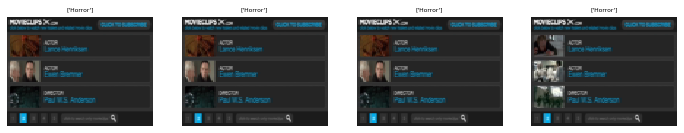

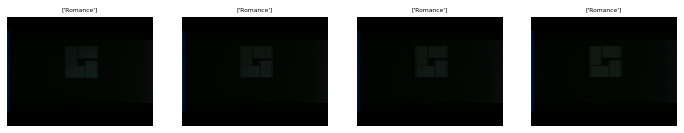

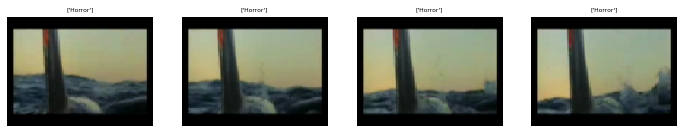

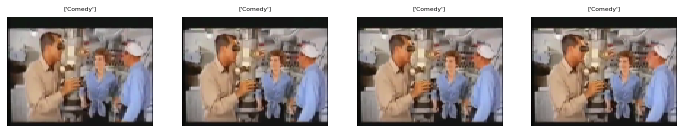

In [35]:
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=6)
        plt.imshow((ims[i] * 255).astype(np.uint8), aspect='auto', interpolation=None if interp else 'none')
def plots2(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=6)
        plt.imshow(np.array(ims[i],np.int32), aspect='auto', interpolation=None if interp else 'none')
               
for j in range(3,4):
    res = train_generator.__getitem__(j)

    print('X: ',res[0].shape)
    print('Y: ',res[1].shape)
    #print(res[1])
    train_generator.on_epoch_end()
    titles = [train_generator.load_label(res[1][k]) for k in range(BATCH_SIZE)]
    #print(titles)
    #print("imgs.shape is : ", imgs.shape)
    #print("labels.shape is : ", labels.shape)
    for k,i in enumerate(res[0][:,0:frame_rate,:,:]):
        
        print(i.shape)
        if preprocess:
            plots(i,titles=[titles[k]]*frame_rate,rows = 1,figsize=(12,2))
        else:
            plots2(i,titles=[titles[k]]*frame_rate,rows = 1,figsize=(12,2))
    #for k,i in enumerate(res[0][:,6:,:,:]):
    #    print(i.shape)
    #    plots2(i,titles=[titles[k]]*frame_rate,rows = 1,figsize=(12,2))    

    #print(labels)

    #plots(imgs[0],titles=labels[0])

# only images


In [52]:
import tensorflow as tf
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.layers import Dense, LSTM, Flatten, Input, TimeDistributed, Conv2D, Dropout,GRU,BatchNormalization,MaxPool2D,GlobalMaxPool2D
inception = InceptionResNetV2(
    include_top=False, weights='imagenet', input_tensor=None,
    input_shape=(input_dim[0], input_dim[1], 3), pooling=None, classes=1000,
    classifier_activation='sigmoid'
)


for layer in inception.layers[:-4]:
    layer.trainable = False# create a Sequential model
model = Sequential()# add vgg model for 5 input images (keeping the right shape
model.add(Input(shape=(input_dim[0], input_dim[1], 3)))
model.add(inception)
model.add(Flatten())
model.add(Dense(1000, activation='sigmoid'))
import tensorflow
optimizer = tensorflow.keras.optimizers.Adam(0.0001)
model.compile(
    optimizer,
    loss= [ 'categorical_crossentropy'],
    metrics=['acc']
)

In [53]:
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 2, 1, 1536)       54336736  
 onal)                                                           
                                                                 
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense_2 (Dense)             (None, 1000)              3073000   
                                                                 
Total params: 57,409,736
Trainable params: 6,269,416
Non-trainable params: 51,140,320
_________________________________________________________________
None


In [103]:
data_dir = "WritingsDetector/WritingsDataset/WritingN"
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="validation",
  shuffle = False,
  seed=123,
  image_size=(input_dim[0], input_dim[1]),
  batch_size=1,
  label_mode=None)


predictions = model.predict(test_ds, verbose = 1)

Found 960 files belonging to 1 classes.
Using 96 files for validation.
96/96 [==============================] - 21s 215ms/step


In [96]:
print(predictions.shape)

(9, 1000)


(16, 130, 100, 3)
(9, 5)


IndexError: ignored

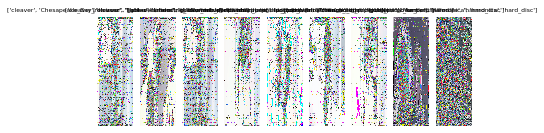

In [97]:
from keras.applications.imagenet_utils import decode_predictions
top_value= 5 
decoded_predictions = decode_predictions(predictions, top = top_value)
ims = np.empty(shape = (16, 130, 100, 3))
LAB = []
for i,images in enumerate(test_ds):
  
    ims[i]= images
    lbls = []
    for top in range(top_value):
        #print(decoded_predictions[i][top])
        (class_name, class_description, score) =  decoded_predictions[i][top]
        lbls.append(class_description)
    LAB.append(lbls)

print(np.array(ims).shape)
print(np.array(LAB).shape)
plots(np.array(ims),titles=LAB,rows = 1, figsize=(12,2))

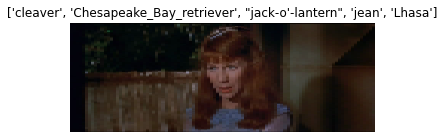

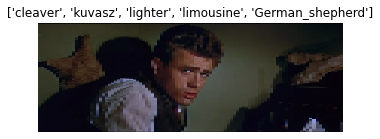

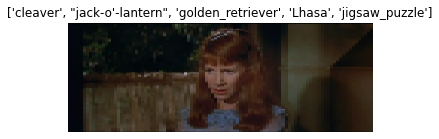

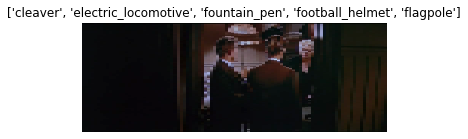

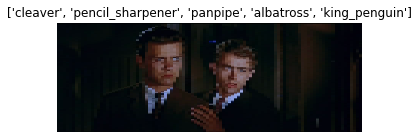

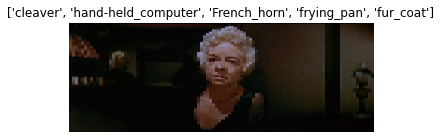

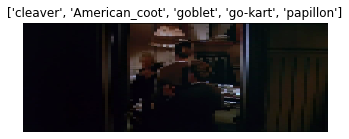

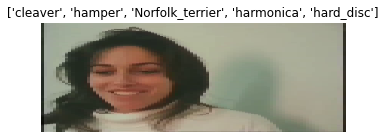

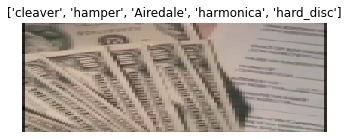

In [102]:
top_value = 5

decoded_predictions = decode_predictions(predictions, top = top_value)
for i,images in enumerate(test_ds):
    x= images
    t = []

    for top in decoded_predictions[i]:
        
            (class_name, class_description, score)= top
            if class_description not in t:
                t.append(class_description)
    

    plots_one_title(images,title=t,rows = 1,fontsize = 12, figsize=(12,2))

#Videos


In [13]:
import tensorflow as tf
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.layers import Dense, LSTM, Flatten, Input, TimeDistributed, Conv2D, Dropout,GRU,BatchNormalization,MaxPool2D,GlobalMaxPool2D

from keras import Sequential
inception = InceptionResNetV2(
    include_top=False, weights='imagenet', input_tensor=None,
    input_shape=(input_dim[0], input_dim[1], 3), pooling=None, classes=1000,
    classifier_activation='sigmoid'
)

for layer in inception.layers[:-4]:
    layer.trainable = False# create a Sequential model
model = Sequential()# add vgg model for 5 input images (keeping the right shape
model.add(Input(shape=(frame_rate,input_dim[0], input_dim[1], 3)))
model.add(TimeDistributed(inception))

model.add(Dense(1000, activation='sigmoid'))
import tensorflow
optimizer = tensorflow.keras.optimizers.Adam(0.0001)
model.compile(
    optimizer,
    loss= [ 'categorical_crossentropy'],
    metrics=['acc']
)
print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 4, 2, 1, 1536)    54336736  
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 4, 2, 1, 1000)    1537000   
 tributed)                                                       
                                                                 
Total params: 55,873,736
Trainable params: 4,733,416
Non-trainable params: 51,140,320
_________________________________________________________________
None


In [15]:
params = {
    'batch_size':1,
    'dim':input_dim,
    'n_classes':num_classes,
    'shuffle':True,
    'csv_file':df_train_ready[300:301],
    'main_genre':main_genre ,
    'x_label' : 'ID_Frame',
    'y_label': 'Genres_subset',
    'cut_points_column' :'Cut_Points',
    'preprocess' : preprocess,
    'size_of_cut_list_column' : 'Number_Scenes',
    'frame_rate': frame_rate,
    'is_test' : True}
test_generator = DataGenerator("Data",**params)

predictions = model.predict(test_generator, verbose = 1)

Found # trailers:  1
Found data size:  2
Found the labels Genres_subset
given the data folder Data
2/2 [==============================] - 6s 474ms/step


In [21]:
print(predictions.shape)
pred2 = predictions.transpose(2,0,1).reshape(1000,-1).transpose(1,0)
print(pred2.shape)

(2, 4, 2, 1, 1000)


ValueError: ignored

In [17]:
from keras.applications.imagenet_utils import decode_predictions
print(decode_predictions(pred2))

NameError: ignored

In [100]:
def plots_one_title(ims, figsize=(12,6), rows=1, interp=False,fontsize=6, title=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)

    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        if i == 0:
            sp.set_title(title, fontsize=fontsize)
        sp.axis('Off')
        plt.imshow(ims[i].numpy().astype("uint8"), aspect='auto', interpolation=None if interp else 'none')
top_value = 15
for j in range(0,1):
    x= test_generator.__getitem__(j)
    t = []
    #print(predictions[j])

    decoded_predictions = decode_predictions(predictions[j,0,:,:],top=top_value)
    for d_pred in decoded_predictions:
        for top in range(top_value):
            (class_name, class_description, score)= d_pred[top]
            if class_description not in t:
                t.append(class_description)
    


    for k,i in enumerate(x):
        plots_one_title(i,title=t,rows = 1,fontsize = 12, figsize=(12,2))

IndexError: ignored